# Init

## Imports

In [1]:
import numpy as np
import matplotlib.pylab as plt

# Example HMC Integrator

## Introduction

The Hybrid Monte Carlo Integration routine samples auxiliary fields $\phi$ in a sophisticated way (the fields $\phi$ are distributed according to a probaility $P(\phi)$), such that the integration over the auxiliary fields becomes the summation over the configurations of auxiliary fields

\begin{equation}
    \int d \phi \, f(\phi) P(\phi)
    =
    \sum _{ \phi \in \Phi } f(\phi)
    \qquad
    \,
    \Phi = \left\{
        \phi \in \mathbb{R} \, \middle\vert \, \mathrm{hist}(\Phi | \phi) =  P(\phi)
    \right\}
    \, .
\end{equation}



In our case, the distributon of auxilary fields is given by

\begin{equation}
    P(\phi)
    = \mathcal{N}\det\left|M(\phi)\right| e^{-\phi^2 / 2}
    = \mathcal{N}\exp\left\{
        - \frac{\phi^2}{2} + \log\left[ \det\left|M(\phi)\right| \right]
    \right\}
    \, .
\end{equation}



The probability is normaized to one, hence one has to determine $\mathcal{N}$.
The trick to generate the distribution looks as following: we add an additional auxiliary field $\pi$, which is distributed according to a gaussian with $\mu=0$ and $\sigma=1$ and treat the resulting probability as the exponentail of a Hamlitonian

\begin{align}
    P(\phi)
    =
    \int \frac{d \pi}{\sqrt{2\pi}} e^{- \pi^2/2} P(\phi)
    =
    \frac{\mathcal{N}}{\sqrt{2\pi}}
    \int d \pi
    \exp\left\{
        - \left( \frac{\pi^2}{2} + \frac{\phi^2}{2} - \log\left[ \det\left|M(\phi)\right|  \right] \right)
    \right\}
    =
    \int d \pi P( \pi, \phi)
    \, ,
\end{align}

and

\begin{equation}
    P( \pi, \phi)
    =
    \frac{\mathcal{N}}{\sqrt{2\pi}}
    \exp\left\{
        - H(\pi, \phi)
    \right\}
    \, , 
    \qquad
    H(\pi, \phi)
    =
    \frac{\pi^2}{2}
    +
    V(\phi)
    \, , \qquad
    V(\phi)
    =
    \frac{\phi^2}{2} - \log\left[ \det\left|M(\phi)\right|  \right]
\end{equation}

Here we can use the Hamlitonian equation of motions in order to update the $\phi$ fields for a given starting point in $\phi$ and $\pi$
\begin{align}
    \dot{\phi} &= \pi \, ,
    &
    \dot{\pi} & = - \frac{\partial \;}{\partial \phi}H(\pi, \phi) = - \frac{\partial \;}{\partial \phi}V( \phi)
    \equiv F(\phi)
    \, .
\end{align}

In the last equation we have defined the force term $F(\phi)$. For the NLEFT algorithm, this is the most expansive term because it depends on the derivative of the fermionic determinant.

Because the $\pi$ fields are distributed according to a Gaussian, we get those guys for free.  Thus we generate a (gaussian) random $\pi$ field in order to update the $\phi$ fields and so on.  After several (sophisticated) updates, we ask if we should accept the new field $\phi$ compared to the inital field $\phi_0$.  The measure is the exponentail of the energy difference (value of the Hamiltonian):
\begin{equation}
    \exp\left\{ -H(\pi, \phi) + H(\pi_0, \phi_0) \right\} > r \in \mathrm{uniform}[0,1]
\end{equation}

We currently use a Leapforg Integrator for integrating the equation of motion.

## Toy Example

To demonstrate the workflow, I have chosen a simple toy example where the determinant of the fermion matrix, the potential and the force are given by

\begin{align}
    \det\left|M(\phi)\right| &= \frac{1 + \phi^2}{\sqrt{8 \pi}}
    && \Rightarrow &
    V(\phi) &= \frac{\phi^2}{2} - \log\left(1 + \phi^2 \right)
    && \Rightarrow &
    F(\phi) &= - \phi + \frac{2 \phi}{1 + \phi^2}
    \, ,
\end{align}

where, I have defined the normalization of the probability $\mathcal N = \frac{1}{\sqrt{8 \pi}}$.

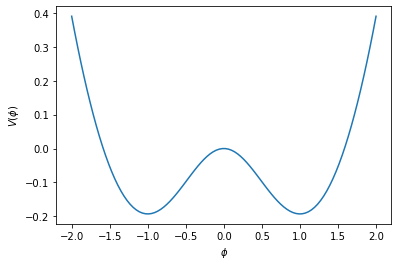

In [2]:
def V(phi):
    return phi ** 2 / 2 - np.log(1 + phi ** 2)


phi = np.linspace(-2, 2, 100)

plt.plot(phi, V(phi))
plt.xlabel("$\phi$")
plt.ylabel("$V(\phi)$")
plt.show()

### How to get the force

I have introduced a toy problem partition function below. It does not really compute the fermionic determinant depending on the wave function, it just returns a standard result. There are also no complex numbers in this example. Nevetheless, this demonstrates the workflow.

In [3]:
class ToyPartitionFunction(object):
    """
        Toy example for partion function for fixed fermi determinant M(phi).
    """

    # -----------------------------------
    def __init__(self, NT, psi0):
        self.NT = NT
        self.psi0 = psi0
        self.psi = range(NT)

    # -----------------------------------
    def evolve_psi(self, phi):
        # T = lambda phint: 1-0.1*phint  # Transfer matrix
        psi_new = [self.psi0]
        # for nt, psi_nt in enumerate(psi):
        #    psi_new += [T(phi[nt]) * psi_nt]
        return psi_new

    # -----------------------------------
    def get_M(self, psi):
        M = []
        # for psi_i in psi[self.NT].nucleons:
        #    row = []
        #    for psi_o in psi[0].nucleons:
        #        row += [psi_i.dot(psi_o)]
        #    M += [row]
        return np.array(M)

    # -----------------------------------
    def get_determinant(self, phi):
        psi_new = self.evolve_psi(phi)
        # det = np.linalg.det(self.get_M(psi_new))
        # return det
        return 1 + np.sum(phi) ** 2

    # -----------------------------------
    def get_V(self, phi):
        det = self.get_determinant(phi)
        V = np.sum(phi) ** 2 / 2 - np.log(det)
        return V

    # -----------------------------------
    def get_F(self, phi):
        # can be expressed by taking the derivative analytically, (not in phi space numerically)
        # F = do_stuff(phi, psi)
        return -phi + 2 * phi / (1 + phi ** 2)

In [4]:
NT = 1
psi0 = 0.1
Z = ToyPartitionFunction(NT, psi0)

psi = np.array([1])

phi = np.array([1])

print(Z.get_M(1))
print(Z.get_determinant(phi))
print(Z.get_V(phi))
print(Z.get_F(phi))

[]
2
-0.1931471805599453
[0.]


## Leapfrog Integrator

In [5]:
class LeapfrogIntegrator(object):
    # -----------------------------------
    def __init__(self, force, N):
        """
            Takes the potential which is used to update the momenta as input as well as the size of vectors.
        """
        self.F = force
        self.N = N
        self.pi_history = []
        self.phi_history = []

    # -----------------------------------
    def update_pi(self, phi, pi, step_size):
        pinew = pi + step_size * self.F(phi)
        self.phi_history.append(phi)
        self.pi_history.append(pinew)
        return pinew

    # -----------------------------------
    def update_phi(self, phi, pi, step_size):
        phinew = phi + step_size * pi
        self.phi_history.append(phinew)
        self.pi_history.append(pi)
        return phinew

    # -----------------------------------
    def integrate(self, NStep, step_size, phi=None, pi=None):
        if pi is None:
            pi = np.random.normal(size=self.N)
        self.pi_history.append(pi)
        if phi is None:
            phi = np.random.normal(size=self.N)
        self.phi_history.append(phi)
        for n in range(NStep):
            phi = self.update_phi(phi, pi, step_size / 2)
            pi = self.update_pi(phi, pi, step_size)
            phi = self.update_phi(phi, pi, step_size / 2)
        return phi, pi

    # -----------------------------------
    def reset_history(self):
        self.pi_history = []
        self.phi_history = []

    # -----------------------------------
    def get_history(self):
        phis = np.array(self.phi_history).astype(float).flatten()
        pis = np.array(self.pi_history).astype(float).flatten()
        return phis, pis

### Toy Example Integration

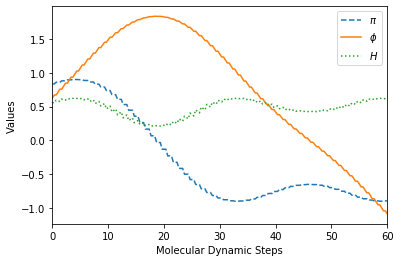

In [6]:
NT = 1
NM = 60
psi0 = 0.1
Z = ToyPartitionFunction(NT, psi0)

integ = LeapfrogIntegrator(Z.get_F, 1)

integ.integrate(NM, 0.1)

phis, pis = integ.get_history()

Hs = []
for pi, phi in zip(pis, phis):
    Hs += [pi ** 2 + Z.get_V(np.array([phi]))]

plt.plot(np.arange(NM * 3 + 1) / 3.0, pis, "--", label="$\pi$")
plt.plot(np.arange(NM * 3 + 1) / 3.0, phis, "-", label="$\phi$")
plt.plot(np.arange(NM * 3 + 1) / 3.0, Hs, ":", label="$H$")

plt.legend()

plt.xlim([0, NM])

plt.xlabel("Molecular Dynamic Steps")

plt.ylabel("Values")

plt.show()

## HMC Evolution

In [7]:
class HMCIntegator(object):
    def __init__(self, potential, force, Nvec=10, fact=1.0 / 10):
        # Probability
        self.V = potential
        self.fact = fact
        # Leapfrog
        self.integ = LeapfrogIntegrator(force, Nvec)
        self.Nvec = Nvec
        self.force = force
        # Computation
        self.ensamble = []
        self.acceptance = []
        self.H = []

    def do_HMC_step(self, NStep, step_size, phi0=None, verbose=False):
        """
            Returns [type phi0] phi_new, [type p0] p_new, [int] acctepted 
        """
        self.integ.reset_history()
        self.integ.integrate(NStep, step_size, phi=phi0)

        phi, pi = self.integ.get_history()

        H0 = np.sum(pi[0] ** 2 / 2 + self.V(phi[0])) * self.fact
        H = np.sum(pi[-1] ** 2 / 2 + self.V(phi[-1])) * self.fact

        r = np.random.uniform(size=1)[0]
        if verbose:
            print(phi0, H0)
            print(phi, H)
            print(np.exp(H0 - H), np.exp(H0 - H) > r)

        if np.exp(H0 - H) > r:  # accept
            return phi[-1], H, 1
        else:
            return phi[0], H0, 0

    def get_ensemble(self, NSample, NTherm=10, step_size=0.1, NStep=10, verbose=False):
        """
            Computes the ensamble of new configurations.
                - [int]   NSample   : The size of the ensamble
                - [int]   NTherm    : The number of thermalization steps (will not be included)
                                      (Does not thermalize if expand is True)
                - [float] step_size : The size of the integrator step
                - [int]   NStep     : The number of integrator steps
                - [bool]  expand    : Speciefies wether to generate a new ensamble or extend an existing one
            
        """
        self.ensamble = []
        self.acceptance = []
        self.H = []

        # Thermalize distribution
        phi = None
        for nc in range(NTherm):
            phi, H, accepted = self.do_HMC_step(
                NStep, step_size, phi0=phi, verbose=False
            )

        # Start sampeling distribution
        for nc in range(NSample):
            phi, H, accepted = self.do_HMC_step(
                NStep, step_size, phi0=phi, verbose=verbose
            )
            self.ensamble.append(phi)
            self.H.append(H)
            self.acceptance.append(accepted)

        acceptance = np.sum(self.acceptance) * 1.0 / len(self.acceptance)

        return acceptance

The next evaluation is a little bit time intensive

### Toy Example Result

In [8]:
NT = 1
NM = 10
psi0 = 0.1
Z = ToyPartitionFunction(NT, psi0)

hmc = HMCIntegator(Z.get_V, Z.get_F, Nvec=1, fact=1.0)

hmc.get_ensemble(10000, NTherm=1000, step_size=0.1, NStep=NM, verbose=False)

0.9994

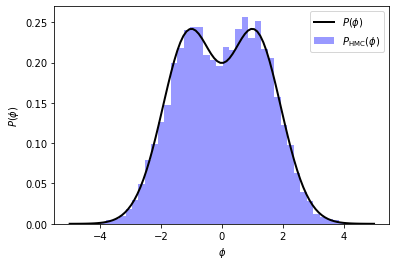

In [9]:
plt.hist(
    hmc.ensamble,
    density=True,
    bins=40,
    alpha=0.4,
    color="blue",
    label="$P_\mathrm{HMC}(\phi)$",
)

phi = np.linspace(-5, 5, 100)

plt.plot(
    phi,
    np.exp(-V(phi)) / np.sqrt(8 * np.pi),
    linewidth=2,
    color="black",
    label="$P(\phi)$",
)

plt.legend(loc="best", frameon=True)

plt.xlabel("$\phi$")
plt.ylabel("$P(\phi)$")

plt.show()